In [1]:
from pathlib import Path
import os
import sys

sys.path.append(str(Path(os.getcwd()).parent))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, classification_report
from math import sqrt

In [6]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, RFE
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap

In [7]:
def regression_report(y_true: np.ndarray, y_pred: np.ndarray) -> None:
    return f"""
MAE: {mean_absolute_error(y_true, y_pred)}
MSE: {mean_squared_error(y_true, y_pred)}
RMSE: {sqrt(mean_squared_error(y_true, y_pred))}
MAPE: {mean_absolute_percentage_error(y_true, y_pred)}
R^2: {r2_score(y_true, y_pred)}
    """


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier

REGRESSOR = LinearRegression
CLASSIFIER = KNeighborsClassifier

SEED = 13

IOC = {
    "report": {
        "regression": regression_report,
        "classification": classification_report
    },
    "model": {
        "regression": REGRESSOR,
        "classification": CLASSIFIER
    }
    
}

In [27]:
def result(type: str, X: np.ndarray, y: np.ndarray, return_estimator=False, **kwargs) -> None:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED)

    model = IOC["model"][type](**kwargs).fit(X_train, y_train)

    print(IOC["report"][type](y_test, model.predict(X_test)))

    if return_estimator:
        return model

# 1 Загрузка данных для классификации

In [28]:
table_classification = pd.read_csv("../data/neo_task_compleated.csv")
table_classification

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,0.016016,0.035813,56014.078517,1.024333e+06,26.10,False
1,0.030518,0.068240,7864.348060,3.268186e+07,24.70,False
2,0.055533,0.124177,55257.544508,6.538636e+07,23.40,False
3,0.019256,0.043057,41531.404722,1.260796e+07,25.70,False
4,0.139494,0.311918,67639.394481,7.130590e+07,21.40,False
...,...,...,...,...,...,...
90831,0.017561,0.039268,23264.740825,1.635007e+06,25.90,False
90832,0.110804,0.247765,24802.519406,3.351901e+07,21.90,False
90833,0.035039,0.078350,116288.999548,5.471396e+07,24.40,False
90834,0.044112,0.098637,45763.317060,2.694877e+07,23.90,False


In [29]:
X_classification = np.array(table_classification.drop(columns=['hazardous'], axis=1))
y_classification = np.array(table_classification['hazardous'])
columns = table_classification.drop(columns=['hazardous'], axis=1).columns

In [30]:
rus = RandomUnderSampler()
X_scaled, y = rus.fit_resample(X_classification, y_classification)

In [31]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X_scaled)

In [32]:
X = pd.DataFrame(X_std, columns=columns)
X

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
0,-0.704966,-0.705368,-1.399718,1.126541,2.032457
1,1.202661,1.208120,0.133656,0.029307,-1.276558
2,-0.696584,-0.696960,-1.793326,-1.331087,1.817035
3,-0.287876,-0.286997,-0.479114,0.068475,-0.146478
4,0.826366,0.830669,-0.136699,-1.189053,-1.110578
...,...,...,...,...,...
17675,-0.180841,-0.179632,-0.227888,0.586816,-0.312459
17676,-0.348568,-0.347875,0.436632,0.698469,-0.033470
17677,-0.087622,-0.086127,1.979383,0.239527,-0.432530
17678,0.004276,0.006053,-0.075472,-0.678160,-0.534943


# 1.1 Тестирование модели на исходных данных

In [33]:
result("classification", X, y, n_neighbors=7)

              precision    recall  f1-score   support

       False       0.93      0.77      0.85      1758
        True       0.81      0.94      0.87      1778

    accuracy                           0.86      3536
   macro avg       0.87      0.86      0.86      3536
weighted avg       0.87      0.86      0.86      3536



In [34]:
X.shape

(17680, 5)

# 1.2 Уменьшение размерности для классификации через отбор признаков

In [35]:
# 1. VarianceThreshold - отбор по дисперсии

vt = VarianceThreshold(1)
X_vt = vt.fit_transform(X)
print(X_vt.shape)
result("classification", X_vt, y, n_neighbors=7)

(17680, 1)
              precision    recall  f1-score   support

       False       0.60      0.58      0.59      1758
        True       0.60      0.62      0.61      1778

    accuracy                           0.60      3536
   macro avg       0.60      0.60      0.60      3536
weighted avg       0.60      0.60      0.60      3536



In [36]:
vt.get_feature_names_out()

array(['relative_velocity'], dtype=object)

In [37]:
# 2. SelectKBest - степень влияния на целевой признак с помощью теста Фишера

skb = SelectKBest(k=2)
X_skb = skb.fit_transform(X, y)
result("classification", X_skb, y, n_neighbors=7)

              precision    recall  f1-score   support

       False       0.93      0.79      0.85      1758
        True       0.82      0.94      0.88      1778

    accuracy                           0.87      3536
   macro avg       0.87      0.86      0.86      3536
weighted avg       0.87      0.87      0.86      3536



In [38]:
skb.get_feature_names_out()

array(['est_diameter_min', 'absolute_magnitude'], dtype=object)

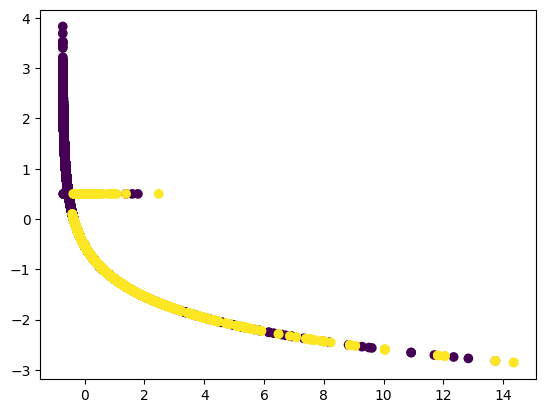

In [39]:
plt.scatter(X_skb[:,0], X_skb[:,1], c=y);

In [40]:
# 3. RFE - рекурсивный отбор признаков относительно индекса информативности решающего дерева

tree = DecisionTreeClassifier().fit(X, y)

rfe = RFE(estimator=tree, n_features_to_select=2, step=1).fit(X, y)
X_rfe = pd.DataFrame(rfe.transform(X), columns=rfe.get_feature_names_out())
rfe.get_feature_names_out()

array(['est_diameter_min', 'relative_velocity'], dtype=object)

In [41]:
result("classification", X_rfe, y, n_neighbors=7)

              precision    recall  f1-score   support

       False       0.94      0.77      0.85      1758
        True       0.81      0.95      0.88      1778

    accuracy                           0.86      3536
   macro avg       0.88      0.86      0.86      3536
weighted avg       0.88      0.86      0.86      3536



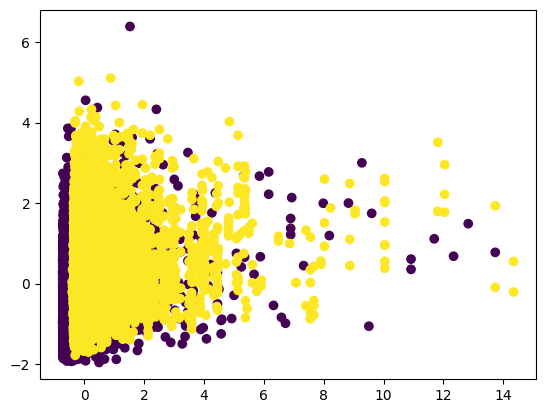

In [42]:
plt.scatter(np.array(X_rfe)[:,0], np.array(X_rfe)[:,1], c=y);

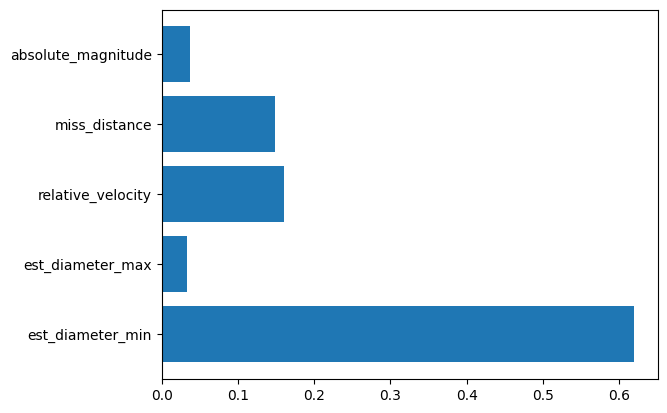

In [43]:
plt.barh(width=tree.feature_importances_, y=X.columns);

# 1.3 Уменьшение размерности для классификации через извлечение новых

In [44]:
# 1. PCA - метод главных компонент

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X, y)
result("classification", X_pca, y, n_neighbors=7)

              precision    recall  f1-score   support

       False       0.93      0.76      0.84      1758
        True       0.80      0.94      0.87      1778

    accuracy                           0.85      3536
   macro avg       0.87      0.85      0.85      3536
weighted avg       0.87      0.85      0.85      3536



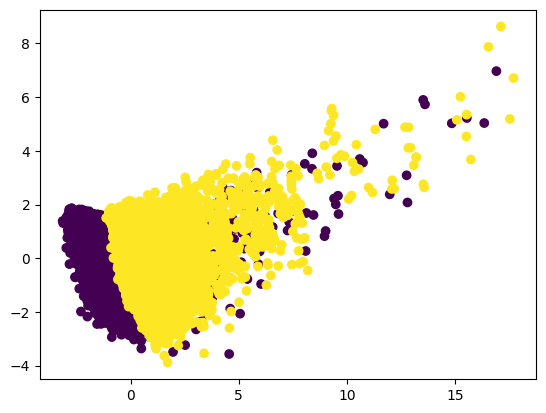

In [45]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=y);

In [286]:
sum(pca.explained_variance_ratio_)

0.7906097129812062

In [287]:
# 2. TSNE - сохранение пропорций между объектами в новом пространстве

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
result("classification", X_tsne, y, n_neighbors=5)

              precision    recall  f1-score   support

       False       0.91      0.77      0.84      1758
        True       0.81      0.92      0.86      1778

    accuracy                           0.85      3536
   macro avg       0.86      0.85      0.85      3536
weighted avg       0.86      0.85      0.85      3536



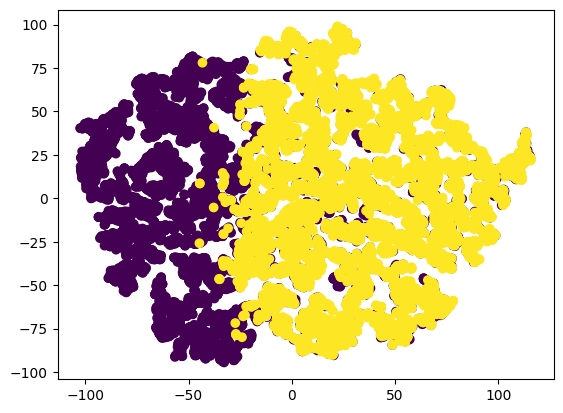

In [288]:
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y);

In [289]:
# 3. Isomap - сохранение геодезических расстояний

isomap = Isomap(n_components=3)
X_isomap = isomap.fit_transform(X)
result("classification", X_isomap, y, n_neighbors=5)

              precision    recall  f1-score   support

       False       0.91      0.77      0.84      1758
        True       0.81      0.92      0.86      1778

    accuracy                           0.85      3536
   macro avg       0.86      0.85      0.85      3536
weighted avg       0.86      0.85      0.85      3536



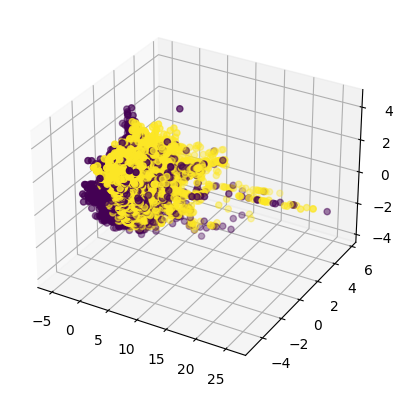

In [290]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_isomap[:,0], X_isomap[:,1], X_isomap[:,2], c=y);

# 1.4 Собственная реализация PCA

In [66]:
from mylib.feature_extraction.PCA import MyPCA

mypca = MyPCA(n_components=2, is_scaled=True)
X_mypca = mypca.fit(np.array(X)).transform(np.array(X))
result("classification", X_mypca, y, n_neighbors=7)

              precision    recall  f1-score   support

       False       0.76      0.68      0.72      1758
        True       0.72      0.79      0.75      1778

    accuracy                           0.74      3536
   macro avg       0.74      0.74      0.74      3536
weighted avg       0.74      0.74      0.74      3536



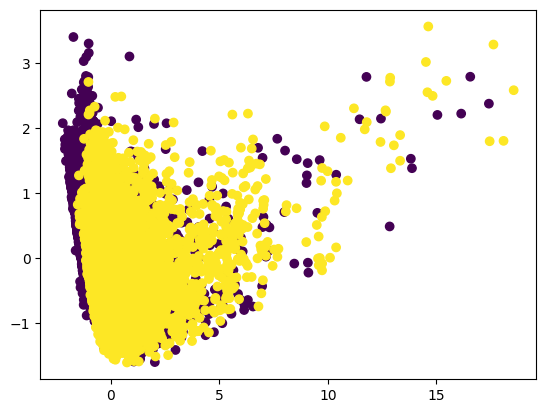

In [68]:
plt.scatter(X_mypca[:,0], X_mypca[:,1], c=y);

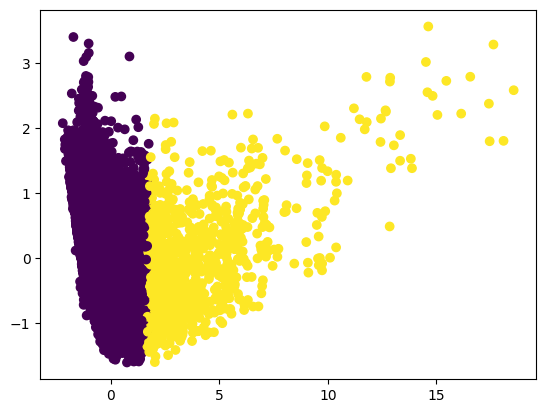

In [72]:
from mylib.clusterization.KMeans import KMeans


kmeans = KMeans(2, 0.01).fit(X_mypca)
plt.scatter(X_mypca[:,0], X_mypca[:,1], c=kmeans.labels_);

# 2 Загрузка данных для регрессии

In [9]:
table_regression = pd.read_csv("../data/energy_task_compleated.csv")
table_regression.drop("Unnamed: 0", axis=1, inplace=True)
table_regression

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,month,day
0,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,45.566667,...,17.033333,45.5300,6.60,733.5,92.000000,7.000000,63.000000,5.3,11.0,1.0
1,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,...,17.066667,45.5600,6.48,733.6,92.000000,6.666667,59.166667,5.2,11.0,1.0
2,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,...,17.000000,45.5000,6.37,733.7,92.000000,6.333333,55.333333,5.1,11.0,1.0
3,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,...,17.000000,45.4000,6.25,733.8,92.000000,6.000000,51.500000,5.0,11.0,1.0
4,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,45.530000,...,17.000000,45.4000,6.13,733.9,92.000000,5.666667,47.666667,4.9,11.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,45.590000,...,23.200000,46.7900,22.70,755.2,55.666667,3.333333,23.666667,13.3,5.0,27.0
19731,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,45.590000,...,23.200000,46.7900,22.60,755.2,56.000000,3.500000,24.500000,13.3,5.0,27.0
19732,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,45.730000,...,23.200000,46.7900,22.50,755.2,56.333333,3.666667,25.333333,13.3,5.0,27.0
19733,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,45.790000,...,23.200000,46.8175,22.30,755.2,56.666667,3.833333,26.166667,13.2,5.0,27.0


In [10]:
X_regression = np.array(table_regression.drop(columns=['Appliances'], axis=1))
y = np.array(table_regression['Appliances'])
columns = table_regression.drop(columns=['Appliances'], axis=1).columns

In [11]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X_regression)

In [12]:
X = pd.DataFrame(X_std, columns=columns)
X

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,month,day
0,3.301264,-1.118645,1.843821,-0.520411,1.077643,-1.235063,1.686130,-0.908217,1.510614,-1.314903,...,-1.219975,0.958068,-0.154029,-2.983278,0.824376,1.207694,2.092418,0.366854,2.272911,-1.457058
1,3.301264,-1.118645,1.616807,-0.520411,1.061009,-1.235063,1.704566,-0.908217,1.608933,-1.314903,...,-1.203398,0.965295,-0.176712,-2.969731,0.824376,1.071703,1.767274,0.343017,2.272911,-1.457058
2,3.301264,-1.118645,1.517959,-0.520411,1.037393,-1.235063,1.748608,-0.944115,1.585267,-1.314903,...,-1.236551,0.950841,-0.197505,-2.956184,0.824376,0.935713,1.442130,0.319180,2.272911,-1.457058
3,4.561378,-1.118645,1.459321,-0.520411,1.028358,-1.235063,1.769092,-0.962063,1.546786,-1.314903,...,-1.236551,0.926750,-0.220188,-2.942636,0.824376,0.799723,1.116986,0.295343,2.272911,-1.457058
4,4.561378,-1.118645,1.526336,-0.520411,1.013572,-1.235063,1.769092,-0.962063,1.502149,-1.296832,...,-1.236551,0.926750,-0.242871,-2.929089,0.824376,0.663733,0.791842,0.271506,2.272911,-1.457058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,-0.479080,2.415962,1.583299,2.530318,0.396446,2.458745,0.590209,1.882026,1.516002,1.955947,...,1.846629,1.261609,2.889282,-0.043506,-1.620336,-0.288198,-1.243842,2.273822,0.250920,1.268508
19731,-0.479080,2.374452,1.568221,2.468301,0.409824,2.425512,0.608646,1.882026,1.516002,1.972211,...,1.846629,1.261609,2.870379,-0.043506,-1.597908,-0.220203,-1.173159,2.273822,0.250920,1.268508
19732,0.781035,2.374452,1.592514,2.411103,0.579507,2.383971,0.752037,1.882026,1.548326,1.972211,...,1.846629,1.261609,2.851477,-0.043506,-1.575479,-0.152208,-1.102475,2.273822,0.250920,1.268508
19733,0.781035,2.374452,1.691361,2.313256,0.645409,2.304213,0.629130,1.882026,1.562179,1.955947,...,1.846629,1.268234,2.813672,-0.043506,-1.553051,-0.084213,-1.031792,2.249985,0.250920,1.268508


# 2.1 Тестирование модели на исходных данных

In [295]:
result("regression", X, y)


MAE: 53.716175906139114
MSE: 9094.50957119359
RMSE: 95.36513813335348
MAPE: 0.6244288251616138
R^2: 0.14963524471609302
    


In [296]:
X.shape

(19735, 27)

# 1.2 Уменьшение размерности для регрессии через отбор признаков

In [297]:
# 1. VarianceThreshold - отбор по дисперсии

vt = VarianceThreshold(1)
X_vt = vt.fit_transform(X)
print(X_vt.shape)
result("regression", X_vt, y)

(19735, 5)

MAE: 59.224787670732766
MSE: 10385.07126972975
RMSE: 101.90716986419429
MAPE: 0.7377139803364461
R^2: 0.028963736883433344
    


In [298]:
vt.get_feature_names_out()

array(['T1', 'RH_2', 'T3', 'T9', 'day'], dtype=object)

In [299]:
# 2. SelectKBest - степень влияния на целевой признак с помощью теста Фишера

skb = SelectKBest(k=14)
X_skb = skb.fit_transform(X, y)
result("regression", X_skb, y)


MAE: 55.06717806279066
MSE: 9510.934380087396
RMSE: 97.52401950333771
MAPE: 0.6443904084675521
R^2: 0.11069823794986067
    


In [300]:
# 3. RFE - рекурсивный отбор признаков относительно индекса информативности решающего дерева

tree = DecisionTreeRegressor().fit(X, y)

rfe = RFE(estimator=tree, n_features_to_select=14, step=1).fit(X, y)
X_rfe = pd.DataFrame(rfe.transform(X), columns=rfe.get_feature_names_out())
rfe.get_feature_names_out()

array(['RH_1', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'RH_5', 'RH_6', 'RH_7',
       'T8', 'RH_8', 'RH_9', 'Press_mm_hg', 'RH_out'], dtype=object)

In [301]:
result("regression", X_rfe, y)


MAE: 55.37230862949586
MSE: 9602.052274872378
RMSE: 97.99006212301519
MAPE: 0.6619529207047976
R^2: 0.10217843314958419
    


# 2.3 Уменьшение размерности для регрессии через извлечение новых

In [302]:
# 1. PCA - метод главных компонент

pca = PCA(n_components=14)
X_pca = pca.fit_transform(X, y)
result("regression", X_pca, y)


MAE: 55.565548778483226
MSE: 9584.636547463111
RMSE: 97.90115702821448
MAPE: 0.651234363744443
R^2: 0.1038068574929244
    


In [305]:
# 2. TSNE - сохранение пропорций между объектами в новом пространстве

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
result("regression", X_tsne, y)


MAE: 60.57889845282451
MSE: 10681.034820852505
RMSE: 103.34909201755237
MAPE: 0.7718211111837014
R^2: 0.001290230054584507
    


In [ ]:
# 3. Isomap - сохранение геодезических расстояний

isomap = Isomap(n_components=3)
X_isomap = isomap.fit_transform(X)
result("regression", X_tsne, y)

# 2.4 Понижение размерности для регрессии через линейные модели

In [13]:
from mylib.regression.LinearRegressionClass import MyLinearRegression_L2

lr = MyLinearRegression_L2(0.2, 0.1).fit(np.array(X), y)
lr.coef[1:]

array([ 2.10225512e-03,  5.90579028e-04,  9.16777630e-04,  1.27925409e-03,
       -6.47439697e-04,  9.06169295e-04,  3.86807733e-04,  4.28955076e-04,
        1.79168592e-04,  2.10293954e-04,  7.74295129e-05,  1.25330001e-03,
       -8.84377602e-04,  2.72520294e-04, -5.92944123e-04,  4.11298614e-04,
       -1.00204979e-03,  1.07277113e-04, -5.48618651e-04,  1.03992957e-03,
       -3.67004790e-04, -1.61583178e-03,  9.28375020e-04,  1.77712076e-06,
        1.63458952e-04, -7.19485024e-05,  2.29184959e-05])

In [14]:
from sklearn.linear_model import Lasso

lr = Lasso(0.6).fit(X, y)

array([ 1.64490344e+01, -7.94119185e+00,  4.43670954e+01, -7.23655530e+00,
       -2.94328898e+01,  3.87594943e+01,  8.21826017e+00, -8.64305227e+00,
       -0.00000000e+00, -2.49788148e+00,  3.60207934e-01,  4.55901329e+00,
        0.00000000e+00, -0.00000000e+00, -1.00528269e+01,  7.31016498e+00,
       -2.28989262e+01, -2.14714783e+01, -1.54606111e+00, -0.00000000e+00,
       -8.73806051e-01, -0.00000000e+00,  3.52237380e+00,  1.05390879e+00,
       -9.22687306e-03, -1.06216538e+00,  1.55751338e+00])

In [19]:
X.columns[lr.coef_ > 0.01]

Index(['lights', 'RH_1', 'T3', 'RH_3', 'RH_5', 'T6', 'T8', 'Windspeed',
       'Visibility', 'day'],
      dtype='object')